In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import PARENT_SMILES, load_data, plot_zero_zero

plt.style.use("default")

In [37]:
path_azaphenalenes = "../../results/azaphenalenes.csv"
path_azulenes = "../../results/azulenes.csv"
path_rational_design = "../../results/rational_design.csv"

path_azaphenalenes_ref = "../../data/reference/azaphenalenes.csv"
path_azulenes_ref = "../../data/reference/azulenes.csv"
path_rational_design_ref = "../../data/reference/rational_design.csv"

df_azaphenalenes = load_data(path_azaphenalenes, path_azaphenalenes_ref).dropna()
df_azulenes = load_data(path_azulenes, path_azulenes_ref).dropna()
df_rational_design = load_data(path_rational_design, path_rational_design_ref).dropna()

In [41]:
jobs = (
    ("Azaphenalenes", df_azaphenalenes),
    ("Azulenes", df_azulenes),
    ("Rational design", df_rational_design),
    # ("Non-alternants", path_garner_non_alternants, path_garner_non_alternants_ref),
    # ("Avoided symmetry", path_garner_avoided_symmetry, path_garner_avoided_symmetry_ref),
    # ("Substituted", path_garner_substituted, path_garner_substituted_ref),
)

results = {}
plot_kwargs = {"edgecolors": "black", "linewidths": 0.5}

for (
    name,
    df,
) in jobs:
    n_neg_t1 = (df["t1_cis"] < 0).sum()
    n_neg_s1 = (df["s1_cis"] < 0).sum()
    n_total = df.shape[0]
    results[name] = {
        "N(neg. triplet)": n_neg_t1,
        "N(neg. singlet)": n_neg_s1,
        "N(total)": n_total,
        "%(neg. triplet)": n_neg_t1 / n_total * 100,
        "%(neg. singlet)": n_neg_s1 / n_total * 100,
    }

<Axes: xlabel='t1_s1_ref', ylabel='t1_s1_dsp_cis'>

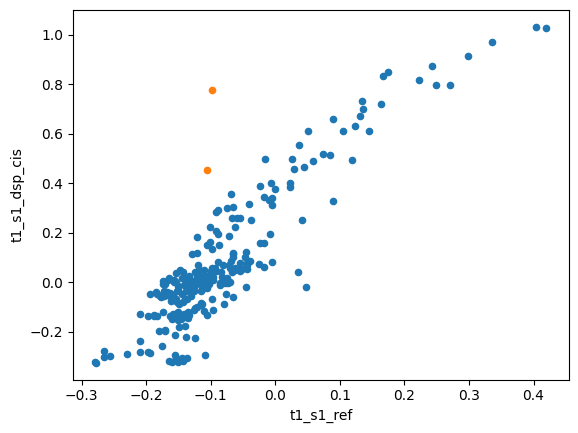

In [50]:
neg_mask = df_azaphenalenes["t1_cis"] < 0
fig, ax = plt.subplots()
df_azaphenalenes[~neg_mask].plot.scatter(
    x="t1_s1_ref", y="t1_s1_dsp_cis", c="C0", ax=ax
)
df_azaphenalenes[neg_mask].plot.scatter(x="t1_s1_ref", y="t1_s1_dsp_cis", c="C1", ax=ax)

NameError: name 'Chem' is not defined

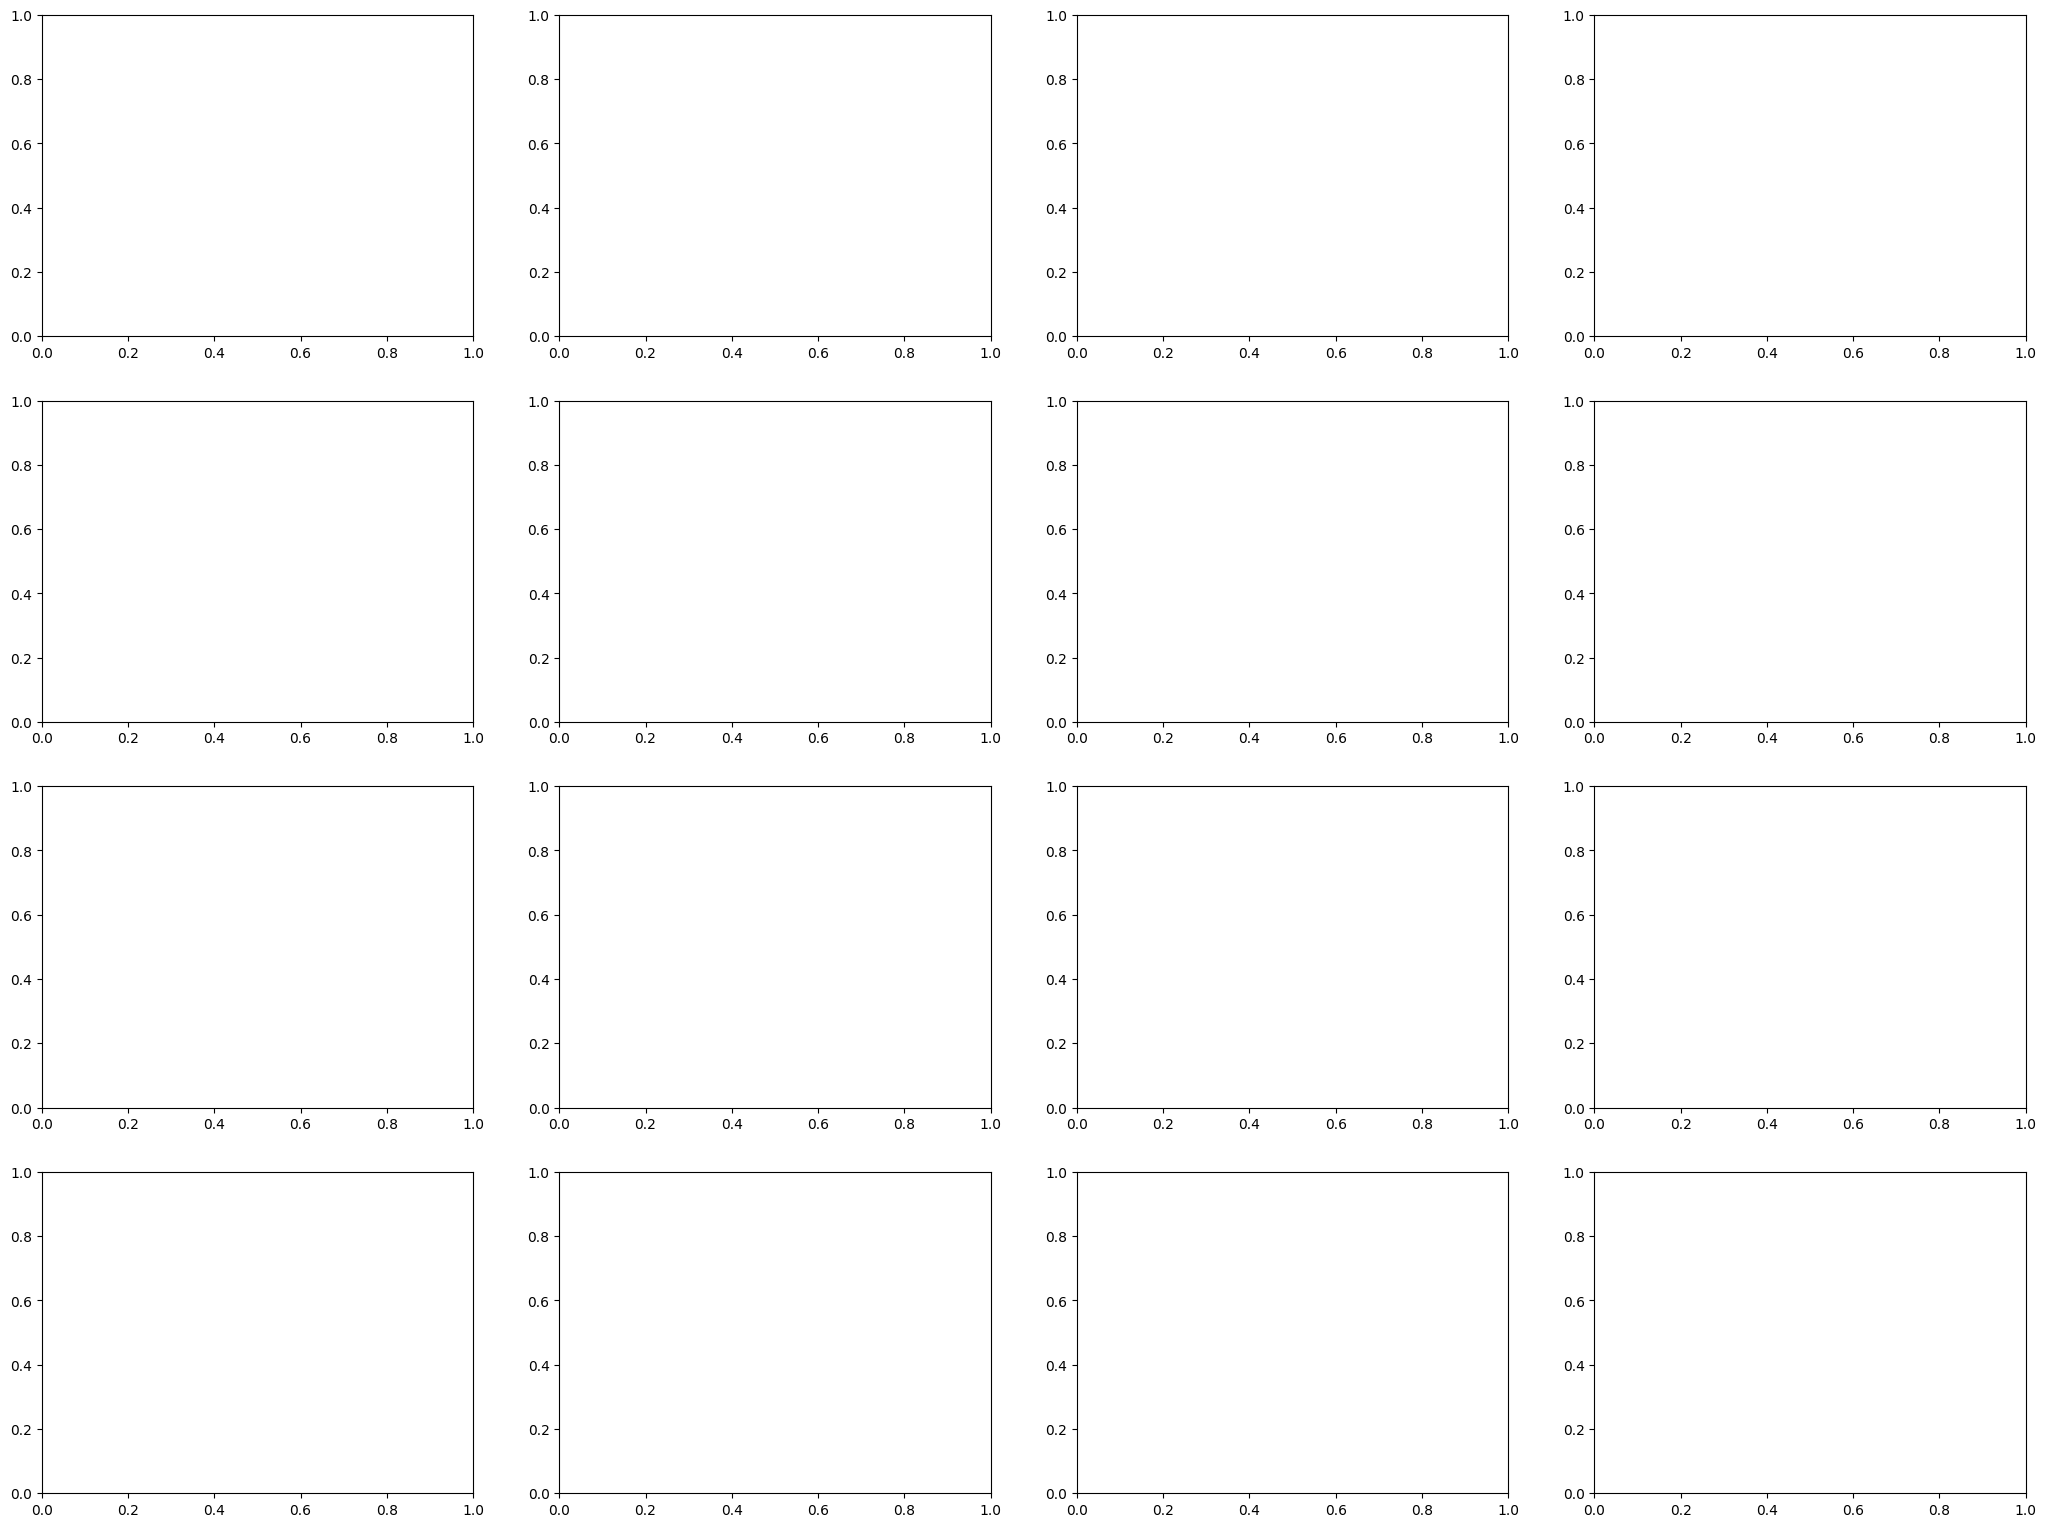

In [55]:
# fig, ax = plt.subplots()
# df_azaphenalenes[~neg_mask].plot.scatter(
#     x="t1_s1_ref", y="t1_s1_dsp_cis", c="C0", ax=ax
# )
# df_rational_design[neg_mask].plot.scatter(x="t1_s1_ref", y="t1_s1_dsp_cis", c="C1", ax=ax)

df_rational_design["scaffold"] = [idx.split("_")[0] for idx in df_rational_design.index]

scaffolds = list(PARENT_SMILES.keys())

n_rows = 4
n_columns = 4
fig, axs = plt.subplots(
    n_columns,
    n_rows,
    figsize=plt.rcParams["figure.figsize"] * np.array([n_rows, n_columns]),
)

for i, scaffold in enumerate(scaffolds):
    df = df_rational_design[df_rational_design["scaffold"] == scaffold]
    neg_mask = df["t1_cis"] < 0

    i_row = i // n_rows
    i_col = i % n_columns
    ax = axs[i_row, i_col]
    # smiles = PARENT_SMILES[scaffold]
    # mol = Chem.MolFromSmiles(smiles)
    # mol_image = draw_mol(mol, img_format="svg")

    # _, _, results = plot_zero_zero(
    #     df,
    #     x_name="t1_s1_ref",
    #     y_name="t1_s1_dsp_cis_corr",
    #     plot_type="scatter",
    #     **plot_kwargs,
    #     fig=fig,
    #     ax=ax,
    #     legend_loc="lower center",
    # )